In [1]:
# [CELL ID] 1

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[CELL ID] 2
## Introduction

As we seek to deploy machine learning systems in the real world, it becomes critical that we examine not only whether the systems don't simply work "most of the time", but which are truly robust and reliable. Although many notions of robustness and reliability exist, one particular topic has raised a great deal of interest in recent years: robustness to adversarial examples. More precisely, can we develop classifiers that are robust to (test time) perturbations of their inputs, by an adversary intending to fool the classifier? 
A few years ago, researchers have shown that neural networks are vulnerable to <em> adversarial examples</em>, i.e. imperceptible variations of natural examples, crafted to deliberately mislead the models.

<img width="500" src="https://languagelog.ldc.upenn.edu/myl/adversarial-example.png">

The purpose of this project is to teach you how these pertubations are crafted and how can we create robust classifier. 

[1] Nightmare at test time: robust learning by feature deletion <br>
[2] Evasion attacks against machine learning at test time <br>
[3] Intriguing properties of neural networks

[CELL ID] 3
## Some introductory notation

Let us consider a model $h_\theta : \mathcal{X} \rightarrow \mathbb{R}^k$ mapping an input $x$, to a vector $h_\theta(x)$ in $\mathbb{R}^k$ (where $k$ is the number of classes being predicted). $h_\theta(x)$ is called a logit vector of the model $h_\theta$ where each coordinate can be positive or negative. The $\theta$ vector represents all the parameters defining this model (for example in a linear model it would represent the slope and the intercept). to get a prediction out of $h_\theta$ for a given $x$, the classical technique is to output the biggest coordinate of \begin{equation}
\DeclareMathOperator*{\argmax}{argmax}
\argmax_{j} h_\theta(x)_j 
\end{equation} where $h_\theta(x)_j$ denotes the $j$th elements of the vector $h_\theta(x)$.

In order the evaluate the quality of prediction of the model on a given example, we use a loss function $\ell: \mathbb{R}^k \times \mathbb{Z}_+ \rightarrow \mathbb{R}_+$ mapping the model predictions and true labels to a non-negative number. The semantics of this loss function are that the first argument is the model output (logits which can be positive or negative), and the second argument is the _index_ of the true class (that is, a number from 1 to $k$ denoting the index of the true label). Thus, the notation
\begin{equation}
\ell(h_\theta(x), y)
\end{equation}
for $x \in \mathcal{X}$ the input and $y \in \mathbb{Z}$ the true class, denotes the loss that the classifier achieves in its predictions on $x$, assuming the true class is $y$.  By far the most common form of loss used in machine learning (especially in deep learning) is the cross entropy loss (also sometimes called the softmax loss), defined as
\begin{equation}
\ell(h_\theta(x), y) = \log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right ) - h_\theta(x)_y
\end{equation}
where $h_\theta(x)_j$ denotes the $j$th elements of the vector $h_\theta(x)$.

Recall that a common approach to training a classifier is to optimize the _parameters_ $\theta$, so as to minimize the average loss over some training set $\{x_i \in \mathcal{X}, y_i \in \mathbb{Z}\}$, $i=1,\ldots,m$, which we write as the optimization problem
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{m} \sum_{i=1}^m \ell(h_\theta(x_i), y_i)
\end{equation}
which we typically solve by (stochastic) gradient descent.  I.e., for some minibatch $\mathcal{B} \subseteq \{1,\ldots,m\}$, we compute the gradient of our loss with respect to the parameters $\theta$, and make a small adjustment to $\theta$ in this negative direction
\begin{equation}
\theta := \theta - \frac{\alpha}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \nabla_\theta \ell(h_\theta(x_i), y_i)
\end{equation}
where $\alpha$ is some step size, and we repeat this process for different minibatches covering the entire training set, until the parameters convergence.

[CELL ID] 4
## Creating an adversarial example

To create an adversarial example, instead of adjusting the parameters $\theta$ with the gradient define above: $\nabla_\theta \ell(h_\theta(x_i), y_i)$, we are going to adjust the image in order to _maximize_ the loss. Therefore, we want to solve the optimization problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\hat{x}} \ell(h_\theta(\hat{x}), y)
\end{equation}
where $\hat{x}$ denotes our adversarial example that is attempting to maximize the loss.

Of course, we cannot just optimize arbitrarily over $\hat{x}$ (there do exist, after all, some images that are _not_ pandas, and if we change the image entirely, say to a dog, then it's not particularly impressive that we can "fool" the classifier into thinking it's not a panda). So we instead need to ensure that $\hat{x}$ is close to our original input $x$. By convention, we typically do this by optimizing over the _perturbation_ to $x$, which we will denote $\delta$
\begin{equation}
\maximize_{\delta \in \Delta} \ell(h_\theta(x +\delta), y)
\end{equation}
where $\Delta$ represents an allowable set of perturbations (typically perturbation that make $x + \tau$ sufficiently close to $x$).  

Characterizing the "correct" set of allowable perturbations is actually quite difficult: in theory, we would like $\Delta$ to capture anything that humans visually feel to be the "same" as the original input $x$.  This can include anthing ranging from adding slight amounts of noise, to rotating, translating, scaling, or performing some 3D transformation on the underlying model, or even completely changing the image in the "non-panda" locations.  Needless to say, it is not possible to give a mathematically rigorous definition of all the perturbations that _should_ be allowed, but the philosophy behind adversarial examples is that we can consider some _subset_ of the possible space of allowed perturbations, such that by any "reasonable" definition, the actual semantic content of the image could not change under this perturbation.

A common perturbation set to use, though by no means the only reasonable choice, is the $\ell_\infty$ ball, defined by the set
\begin{equation}
\Delta = \{\delta : \|\delta\|_\infty \leq \epsilon\}
\end{equation}
where the $\ell_\infty$ norm a vector $z$ is defined as
\begin{equation}
\|z\|_\infty = \max_i |z_i|
\end{equation}
i.e., we allow the perturbation to have magnitude between $[-\epsilon, \epsilon]$ in each of its components (it is a slightly more complex, as we also need to ensure that $x + \delta$ is also bounded between $[0,1]$ so that it is still a valid image).  

[CELL ID] 5
## Binary classification

Let's begin first by considering a simplified problem where $h_\theta$ is a linear classifier (see below) and k=2.  In this case called binary classification, rather than use multi-class cross entropy loss, we'll be adopting the more common approach and using the binary cross entropy, or logistic loss. In this setting, we have our hypothesis function
\begin{equation}
h_\theta(x) = w^T x + b
\end{equation}
for $\theta = \{w \in \mathbb{R}^n, b \in \mathbb{R}\}$, class label $y \in \{+1,-1\}$, and loss function
\begin{equation}
\ell(h_\theta(x), y) = \log(1+\exp(-y\cdot h_\theta(x))) \equiv L(y \cdot h_\theta(x))
\end{equation}
where for convience below we define the function $L(z) = \log(1+\exp(-z))$ which we will use below when discussing how to solve the optimization problems involving this loss.  The semantics of this setup are that for a data point $x$, the classifier predicts class $+1$ with probability
\begin{equation}
p(y=+1|x) = \frac{1}{1 + \exp(-h_\theta(x))}.
\end{equation}


[CELL ID] 6
### Computing an Adversarial pertubation

Let us consider the creation of an adversarial example in the context of binary classification:
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(w^T (x+\delta), y) \equiv \maximize_{\|\delta\| \leq \epsilon} L(y \cdot (w^T(x+\delta) + b)).
\end{equation}
The key point we need to make here is that in this setting, it is actually possible to solve this maximization problem exactly. 

Because the function is monotonic decreasing, if we want to maximize this function applied to a scalar, that is equivalent to just minimizing the scalar quantity.  That is
\begin{equation}
\begin{split}
\DeclareMathOperator*{\minimize}{minimize}
\max_{\|\delta\| \leq \epsilon} L \left(y \cdot (w^T(x+\delta) + b) \right) & =
L\left( \min_{\|\delta\| \leq \epsilon}  y \cdot (w^T(x+\delta) + b) \right) \\
& = L\left(y\cdot(w^Tx + b) + \min_{\|\delta\| \leq \epsilon} y \cdot w^T\delta  \right)
\end{split}
\end{equation}
where we get the second line by just distributing out the linear terms.

Thanks to this simplification of the initial problem, we only need to consider how to solve the problem
\begin{equation}
\min_{\|\delta\| \leq \epsilon} y \cdot w^T\delta.
\end{equation}
To get the intuition here, let's just consider the case that $y = +1$, and consider an $\ell_\infty$ norm constraint $\|\delta\|_\infty \leq \epsilon$.  Since the $\ell_\infty$ norm says that each element in $\delta$ must have magnitude less than or equal $\epsilon$, we clearly minimize this quantity when we set $\delta_i = -\epsilon$ for $w_i \geq 0$ and $\delta_i = \epsilon$ for $w_i < 0$.  For $y = -1$, we would just flip these quantities.  That is, the optimal solution to the above optimization problem for the $\ell_\infty$ norm is given by
\begin{equation}
\delta^\star = - y \epsilon \cdot \mathrm{sign}(w)
\end{equation}

### Exercice 1

Let's see what this looks like for an actual linear classifier.  In doing so, we can also get a sense of how well traditional linear models might work to also prevent adversarial examples.

1. Define and train with gradient descent a linear model using the PyTorch library a binarize version of the MNIST dataset
2. Evaluate your model on the train and test dataset 
3. Create adversarial pertubation on the images of the test set and evaluate the performance of your model <em>under attack</em>
4. Evaluate the visibility of the pertubation by ploting the natural image next to the adversarial image 
5. Make a small analysis and conclusion

In [2]:
# [CELL ID] 7

# binary MNIST dataset
def load_binary_mnist(split, batch_size):
  train = True if split == 'train' else False
  dataset = datasets.MNIST("./data", train=split, download=True, transform=transforms.ToTensor())
  idx = dataset.targets <= 1
  dataset.data = dataset.data[idx]
  dataset.targets = dataset.targets[idx]
  return DataLoader(dataset, batch_size=batch_size, shuffle=train)

batch_size = 100
train_loader = load_binary_mnist('train', batch_size)
test_loader = load_binary_mnist('test', batch_size)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# [CELL ID] 8


class Flatten(torch.nn.Module):
  
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.shape[0], -1)


# Define your model
class Model(torch.nn.Module):  
  
  def __init__(self, input_dim, output_dim):
    super(Model, self).__init__()
    # code here ...
    self.flatten = Flatten()
    self.linear = torch.nn.Linear(input_dim, output_dim)
    
  def forward(self, x):
    # code here ...
    x1 = self.flatten(x)
    return self.linear(x1)


In [11]:


input_dim = 28*28
output_dim = 2
model = Model(input_dim, output_dim)

# define your loss
criterion = torch.nn.CrossEntropyLoss() # code here ...

# define your optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-1) # code here ...

epochs = 11
# train your model
for epoch in range(epochs):
  for batch_n, (imgs, labels) in enumerate(train_loader):
    # code here ...
    y_pred = model(imgs)
    loss = criterion(y_pred, labels)
    if batch_n % 100 == 99:
      print("epoch =", epoch, "err =", loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    opt.zero_grad()
    loss.backward()
    opt.step()

epoch = 0 err = 0.007771406788378954
epoch = 1 err = 0.01717621646821499
epoch = 2 err = 0.020908446982502937
epoch = 3 err = 0.035813212394714355
epoch = 4 err = 0.008993338793516159
epoch = 5 err = 0.004708507563918829
epoch = 6 err = 0.0013373543042689562
epoch = 7 err = 0.002085018204525113
epoch = 8 err = 0.00129212555475533
epoch = 9 err = 0.0009216112084686756
epoch = 10 err = 0.0008965844172053039


In [9]:
# [CELL ID] 9

# evalutation on test set
accuracy = 0.
n_inputs = 0.
with torch.no_grad():
  for n_batch, (imgs, labels) in enumerate(test_loader):
    # code here ...
    y_pred = model(imgs)
    print(y_pred.shape)
    max_value, predicted = torch.max(y_pred.data, 1) # predicted is the index of the max value
    n_inputs += labels.size(0)
    accuracy += (predicted == labels).sum()

print("accuracy = ", accuracy/n_inputs)

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

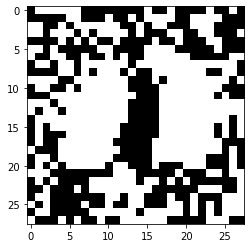

In [ ]:
# [CELL ID] 10

# compute and plot the adversarial pertubation
eps = 0.2
delta = eps * model.linear.weight[1].detach().sign()
plt.imshow(1 - delta.reshape(28, 28), cmap="gray")
plt.show()

In [ ]:
# [CELL ID] 11

# make an evaluation "under attack"
accuracy = 0.
n_inputs = 0.
delta = delta.view(-1, 28, 28)

for n_batch, (imgs, labels) in enumerate(test_loader):
  # code here ...
  normalized_labels = (2*labels - 1)[:,None,None,None]
  
  #print(imgs.shape, delta.shape, normalized_labels.shape)
  
  delta_imgs = imgs - normalized_labels*delta
  y_pred = model(delta_imgs)

  max_value, predicted = torch.max(y_pred.data, 1) # predicted is the index of the max value
  n_inputs += labels.size(0)
  accuracy += (predicted == labels).sum()

print("accuracy = ", accuracy/n_inputs)

accuracy =  tensor(0.2947)
